In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [51]:
df1 = pd.read_csv('data/raw_data/Traffic_Crashes_Crashes.csv', low_memory=False)

In [52]:
df2 = pd.read_csv('data/raw_data/Traffic_Crashes_Vehicle.csv', low_memory=False)

In [53]:
df3 = pd.read_csv('data/raw_data/Traffic_Crashes_People.csv', low_memory=False)

In [54]:
df_crash = df1.copy()
df_vehicle = df2.copy()
df_people = df3.copy()

***
# Cleaning Crashes

In [55]:
# drop columns that are not relevant to "Car Crash Contributors". For example, information about the injury severity does not 
# tell us a contributing factor to a crash.

not_relevant_info = ['RD_NO', 'CRASH_DATE', 'CRASH_DATE_EST_I', 'LANE_CNT', 'REPORT_TYPE', 'CRASH_TYPE', \
                     'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'DATE_POLICE_NOTIFIED', 'DAMAGE', 'NUM_UNITS', \
                     'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'FIRST_CRASH_TYPE', \
                     'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'ALIGNMENT', \
                     'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', \
                     'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', \
                     'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', \
                     'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', \
                     'LOCATION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT']

df_crash.drop((not_relevant_info), axis = 1, inplace = True)
df_crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554228 entries, 0 to 554227
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          554228 non-null  object 
 1   TRAFFIC_CONTROL_DEVICE   554228 non-null  object 
 2   DEVICE_CONDITION         554228 non-null  object 
 3   WEATHER_CONDITION        554228 non-null  object 
 4   LIGHTING_CONDITION       554228 non-null  object 
 5   TRAFFICWAY_TYPE          554228 non-null  object 
 6   ROADWAY_SURFACE_COND     554228 non-null  object 
 7   ROAD_DEFECT              554228 non-null  object 
 8   PRIM_CONTRIBUTORY_CAUSE  554228 non-null  object 
 9   SEC_CONTRIBUTORY_CAUSE   554228 non-null  object 
 10  LATITUDE                 551029 non-null  float64
 11  LONGITUDE                551029 non-null  float64
dtypes: float64(2), object(10)
memory usage: 50.7+ MB


In [56]:
# df_crash.dropna(subset = ['LATITUDE', 'LONGITUDE'], inplace = True)
# from folium.plugins import FastMarkerCluster
# import folium


# my_map = folium.Map([df_crash['LATITUDE'].mean(), df_crash['LONGITUDE'].mean()], zoom_start=9)

# my_map.add_child(FastMarkerCluster(df_crash[['LATITUDE', 'LONGITUDE']].values.tolist()))
# my_map

In [57]:
# Helper Functions
def traffic_control_transfomer(val):
    if val in relevant_device_present:
        return 1
    else:
        return 0
    
def device_working(val):
    if val in working_devices:
        return 1
    else:
        return 0

def device_present(val):
    if val == True:
        return 1
    else:
        return 0

def weather_condition(val):
    if val in bad_weather_cond:
        return 1
    else:
        return 0

def visibility(val):
    if val in bad_visibility:
        return 1
    else:
        return 0

def trafficway_danger(val):
    if val == 'NOT DIVIDED':
        return 1
    else:
        return 0

def road_cond(val):
    if val in bad_road_cond:
        return 1
    else:
        return 0

def defect_road(val):
    if val in road_defect:
        return 1
    else:
        return 0
    
def crash_cause(val):
    if val in driving:
        return 1
    elif val in behavior:
        return 2
    elif val in road:
        return 3
    else:
        return 4

def two(val):
    if val == False:
        return 0
    else:
        return 1

In [58]:
# Initialize list to help map columns from object to int64 based upon the 4 main factors
relevant_device_present = ['TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'OTHER', 'LANE USE MARKING', 'YIELD', 'OTHER REG. SIGN', \
                 'OTHER WARNING SIGN', 'RAILROAD CROSSING GATE', 'PEDESTRIAN CROSSING SIGN', 'POLICE/FLAGMAN', 'SCHOOL ZONE', \
                 'DELINEATORS', 'FLASHING CONTROL SIGNAL', 'BICYCLE CROSSING SIGN', 'NO PASSING', 'RR CROSSING SIGN']
working_devices = ['FUNCTIONING PROPERLY', 'WORN REFLECTIVE MATERIAL']
bad_weather_cond = ['RAIN', 'SNOW', 'FOG/SMOKE/HAZE', 'SLEET/HAIL', 'FREEZING RAIN/DRIZZLE', 'BLOWING SNOW', \
                   'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT']
bad_visibility = ['DARKNESS', 'DUSK', 'DAWN']
bad_road_cond = ['WET', 'SNOW OR SLUSH', 'ICE', 'SAND, MUD, DIRT']
road_defect = ['RUT, HOLES', 'WORN_SURFACE']

In [59]:
# Map all columns to int64 to model
df_crash['BAD_WEATHER'] = df_crash['WEATHER_CONDITION'].map(weather_condition)
df_crash['BAD_VISIBILITY'] = df_crash['LIGHTING_CONDITION'].map(visibility)
df_crash['BAD_TRAFFIC'] = df_crash['TRAFFICWAY_TYPE'].map(trafficway_danger)
df_crash['BAD_ROAD_CONDITION'] = df_crash['ROADWAY_SURFACE_COND'].map(road_cond)
df_crash['DEFECT_ROAD'] = df_crash['ROAD_DEFECT'].map(defect_road)

df_crash['TRAFFIC_DEVICE_PRESENT'] = df_crash['TRAFFIC_CONTROL_DEVICE'].map(traffic_control_transfomer)
df_crash['DEVICE_WORKING'] = df_crash['DEVICE_CONDITION'].map(device_working)

In [60]:
# Final 'Device' column that returns "1" when the traffice device is both present, AND working.
device_list = (df_crash['TRAFFIC_DEVICE_PRESENT'] == 1) & (df_crash['DEVICE_WORKING'] == 1)
device_dataframe = pd.DataFrame(device_list, columns = ['TRAFFIC_DEVICE'], index = df_crash.index)
frames = [df_crash, device_dataframe]
df_crash = pd.concat(frames, axis = 1)
df_crash['WORKING_TRAFFIC_DEVICE'] = df_crash['TRAFFIC_DEVICE'].map(device_present)

In [61]:
# List for mapping "PRIMARY CONTRIBUTORY CAUSE" as recorded by officer at scene.
driving = ['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO REDUCE SPEED TO AVOID CRASH', \
          'IMPROPER BACKING', 'IMPROPER LANE USAGE', 'IMPROPER TURNING/NO SIGNAL', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', \
          'DISREGARDING TRAFFIC SIGNALS', 'DISREGARDING STOP SIGN', 'DISTRACTION - FROM INSIDE VEHICLE', 'DRIVING ON WRONG SIDE/WRONG WAY', \
          'DISTRACTION - FROM OUTSIDE VEHICLE', 'EXCEEDING AUTHORIZED SPEED LIMIT', 'EXCEEDING SAFE SPEED FOR CONDITIONS', \
          'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING ROAD MARKINGS', 'TURNING RIGHT ON RED', 'RELATED TO BUS STOP', 'DISREGARDING YIELD SIGN', \
           'PASSING STOPPED SCHOOL BUS']
behavior = ['PHYSICAL CONDITION OF DRIVER', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' \
           'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 'CELL PHONE USE OTHER THAN TEXTING', \
           'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'TEXTING', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)']
road = ['WEATHER', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', \
       'ROAD CONSTRUCTION/MAINTENANCE']
other = ['EQUIPMENT - VEHICLE CONDITION', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST', 'ANIMAL', \
         'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'OBSTRUCTED CROSSWALKS', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']

df_crash['Target1'] = df_crash['PRIM_CONTRIBUTORY_CAUSE'].map(crash_cause)

In [62]:
# 
# for index, row in df_crash.iterrows(): 
#     if df_crash.loc[index,'PRIM_CONTRIBUTORY_CAUSE'] == 'UNABLE TO DETERMINE':
#         if (df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE'] != 'UNABLE TO DETERMINE') & (df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE'] != 'NOT APPLICABLE'):
#             df_crash.loc[index,'PRIM_CONTRIBUTORY_CAUSE'] = df_crash.loc[index,'SEC_CONTRIBUTORY_CAUSE']

In [63]:
# Converting 'UNABLE TO DETERMINE' columns to be recorded as "road" when 'BAD ROAD CONDITION' is also true
df_crash['is_two'] = (df_crash['Target1'] == 4) & (df_crash['BAD_ROAD_CONDITION'] == 1)
df_crash['Target'] = df_crash['Target1'] + df_crash['is_two']
df_crash['is_two'] = df_crash['is_two'].map(two)

df_crash['Target'] = df_crash['Target1'] + df_crash['is_two']

In [64]:
# Had to separate this helper function due to Python errors
def road(val):
    if val == 5:
        return 2
    else:
        return val
df_crash['Target'] = df_crash['Target'].map(road)

In [65]:
# Drop transformed columns to have final clean dataset
unnecessary_traffic_columns = ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'TRAFFIC_DEVICE_PRESENT', 'DEVICE_WORKING', \
                              'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', \
                              'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'TRAFFIC_DEVICE', 'Target1', 'is_two']
df_crash.drop(unnecessary_traffic_columns, axis = 1, inplace = True)

In [66]:
df_crash.to_csv('data/cleaned_data/cleaned_crash_data.csv')

***
# Cleaning People

In [67]:
df_people.drop(['PERSON_ID', 'PERSON_TYPE', 'RD_NO', 'VEHICLE_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 
         'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION', 
         'INJURY_CLASSIFICATION', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 
         'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE'], axis=1, inplace=True)
df_people.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE', 'AGE', 'DRIVER_ACTION',
       'DRIVER_VISION', 'PHYSICAL_CONDITION'],
      dtype='object')

In [68]:
#Drop missing and null values
df_people.dropna(subset=['AGE'], inplace=True)
df_people.dropna(subset=['DRIVER_ACTION'], inplace=True)
df_people.dropna(subset=['DRIVER_VISION'], inplace=True)
df_people.dropna(subset=['PHYSICAL_CONDITION'], inplace=True)

In [69]:
#Cleaning the 3 columns with many unknown values
df_people = df_people[df_people['DRIVER_VISION']!='UNKNOWN']
df_people = df_people[df_people['DRIVER_ACTION']!='UNKNOWN']
df_people = df_people[df_people['PHYSICAL_CONDITION']!='UNKNOWN']

In [70]:
#Formatting, cleaning, and binning the AGE column. 15 is the youngest age to legally drive in the state of Illinois
#with a learner's permit. 
df_people = df_people[df_people['AGE']>=15]
bins = [14, 23, 64, np.inf]
names = ['15-23', '24-64', '65+']
df_people['AGE_RANGES'] = pd.cut(df_people['AGE'], bins, labels=names)
print(df_people['AGE_RANGES'].value_counts())

24-64    359431
15-23     55573
65+       35406
Name: AGE_RANGES, dtype: int64


In [71]:
dangerous_beh = ['IMPAIRED - ALCOHOL', 'FATIGUED/ASLEEP', 'EMOTIONAL', 'ILLNESS/FAINTED', 'HAD BEEN DRINKING', 
                 'IMPAIRED - DRUGS', 'IMPAIRED - ALCOHOL AND DRUGS', 'MEDICATED']

def physical_condition(val):
    if val in dangerous_beh:
        return 1
    else:
        return 0
    
df_people['DANGEROUS_BEH'] = df_people['PHYSICAL_CONDITION'].map(physical_condition)

In [72]:
bad_vision = ['OTHER', 'MOVING VEHICLES', 'PARKED VEHICLES', 'WINDSHIELD (WATER/ICE)', 'BLINDED - SUNLIGHT', 'HILLCREST',
             'EMBANKMENT', 'BLOWING MATERIALS', 'SIGNBOARD']

def obscured_vision(val):
    if val in bad_vision:
        return 1
    else:
        return 0
    
df_people['OBSCURED_VIZ'] = df_people['DRIVER_VISION'].map(obscured_vision)

In [73]:
bad_action = ['OTHER', 'FAILED TO YIELD', 'FOLLOWED TOO CLOSELY', 'IMPROPER TURN', 'IMPROPER BACKING', 'IMPROPER LANE CHANGE',
             'IMPROPER PASSING', 'TOO FAST FOR CONDITIONS', 'DISREGARDED CONTROL DEVICES', 'IMPROPER PARKING',
             'WRONG WAY/SIDE', 'CELL PHONE USE OTHER THAN TEXTING', 'OVERCORRECTED', 'EMERGENCY VEHICLE ON CALL',
             'EVADING POLICE VEHICLE', 'TEXTING', 'STOPPED SCHOOL BUS', 'LICENSE RESTRICTIONS']

def driver_error(val):
    if val in bad_action:
        return 1
    else:
        return 0
    
df_people['DRIVER_ERROR'] = df_people['DRIVER_ACTION'].map(driver_error)

In [74]:
highrisk_ages = ['15-23', '65+']

def ages(val):
    if val in highrisk_ages:
        return 1
    else:
        return 0
    
df_people['HIGHRISK_AGERANGES'] = df_people['AGE_RANGES'].map(ages)

In [75]:
unnecessary_columns = ['AGE', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'AGE_RANGES']
df_people.drop(unnecessary_columns, axis = 1, inplace=True)

In [76]:
df_people.to_csv('data/cleaned_data/cleaned_people_data.csv')

***
# Cleaning Vehicles

In [77]:
df_vehicle = df_vehicle[['CRASH_RECORD_ID', 'NUM_PASSENGERS', 'VEHICLE_DEFECT',]]

In [78]:
No_def = ['NONE', 'UNKNOWN']

def veh_defect(val):
    if val in No_def:
        return 0
    else:
        return 1
    
df_vehicle['VEHICLE_DEFECT'] = df_vehicle['VEHICLE_DEFECT'].map(veh_defect)


def passengers(val):
    if val >= 1:
        return 1
    else:
        pass

df_vehicle['NUM_PASSENGERS'] = df_vehicle['NUM_PASSENGERS'].map(passengers)

In [79]:
df_vehicle.NUM_PASSENGERS = df_vehicle.NUM_PASSENGERS.fillna(0)

In [80]:
df_vehicle.to_csv('data/cleaned_data/cleaned_vehicle_data.csv')

In [81]:
main_df = df_crash.merge(df_vehicle, on='CRASH_RECORD_ID', how='inner').merge(df_people, on='CRASH_RECORD_ID', how='inner')
main_df.to_csv('data/cleaned_data/cleaned_modeling_data.csv')

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### First Simple Model (FSM) - "Dummy" Model

In [28]:
# main_df['Target'].value_counts()

In [29]:
X = main_df.drop(['CRASH_RECORD_ID','CRASH_DATE', 'Target'], axis=1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# X.columns

In [31]:
fsm_dummy = DummyClassifier(strategy='most_frequent')
fsm_dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [32]:
fsm_cv = cross_val_score(fsm_dummy, X_train, y_train, cv=5)
fsm_cv

array([0.67436161, 0.67436161, 0.67436862, 0.67436862, 0.67436161])

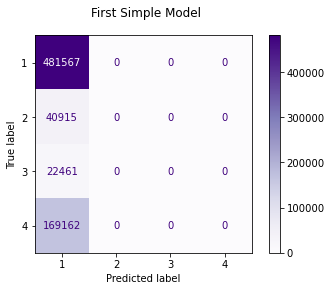

In [33]:
fig, ax = plt.subplots()
fig.suptitle('First Simple Model')
plot_confusion_matrix(fsm_dummy, X_train, y_train, ax=ax, cmap='Purples');

In [80]:
481103/(481103+41379+22461+169162)

0.6737146498064011

In [35]:
dt = DecisionTreeClassifier(random_state = 1)

X = df_crash.drop(['Target1', 'CRASH_RECORD_ID'], axis = 1)
y = df_crash['Target1']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
plot_confusion_matrix(dt, X_test, y_test)

In [ ]:
bayes = CategoricalNB()
ohe = OneHotEncoder()
logreg = LinearSVC()
rf = RandomForestClassifier()
ovr = OneVsRestClassifier(logreg)

In [ ]:
main_df.info()

In [ ]:
dt = DecisionTreeClassifier(random_state = 1, max_depth=100)
X = main_df.drop(['Target1', 'CRASH_RECORD_ID'], axis=1)
y = main_df.Target1

X = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [ ]:
ovr.fit(X_train, y_train)
dt.fit(X_train, y_train)
print('One vs Rest Score: {}'.format(ovr.score(X_train, y_train)))
print('Decision Tree Score: {}'.format(dt.score(X_train, y_train))) 

In [ ]:
plot_confusion_matrix(dt, X_test, y_test);

In [ ]:
# train_pred = ovr.predict(X_train)
# train_pred = label_binarize(train_pred, classes=len(main_df.Target1))
# y_test = label_binarize(y_test, classes=len(main_df.Target1))


In [ ]:
# roc_auc_score(y_train, train_pred, multi_class='ovo', average='macro')

In [ ]:
X2 = main_df.drop(['Target1', 'CRASH_RECORD_ID', 'MAKE', 'MODEL', 'CRASH_DATE', 'AGE'], axis=1)
y2 = main_df.Target1

X2 = ohe.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 1)


In [ ]:
ovr.fit(X_train2, y_train2)
dt.fit(X_train2, y_train2)
print('One vs Rest Score: {}'.format(ovr.score(X_train2, y_train2)))
print('Decision Tree Score: {}'.format(dt.score(X_train2, y_train2))) 

## Pipelines

In [ ]:
pipeline_1 = Pipeline([('ss', StandardScaler()), 
                        ('RF', RandomForestClassifier(random_state = 1,  max_depth=100))])

In [ ]:
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [0.1, 1.0, 10], 
         'RF__min_samples_leaf': [0.1, 0.5, 5]}]
GS = GridSearchCV(estimator=pipeline_1, 
                          param_grid=grid, 
                          scoring='precision', 
                          cv=5)

In [ ]:
#GS.fit()

In [ ]:
#GS.cv_results_

In [ ]:
#GS.best_estimator_.score()

In [ ]:
#GS.best_params_

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***